
# Finite Element Method for Evaporation

Suppose we have a couple of fluid streams exchanging heat (or mass) and want to compute the amount of heat (or mass) exchanged under given conditions of flow configuration and overall heat transfer coefficient U and area through the process. Furthermore, the streams are real -- defined numerically by points (Q,T) or an interpolate, instead of constant stream heat capacity. We want a method that converges with spatial resolution and converges with time for steady-state boundary conditions, and that hopefully gives a reasonable guess for transient conditions. Let's start with some assumptions:

- We want a method that is first order in time, and preferably explicit.
- The method may be spatially implicit.
- The inlets (fluid state and rate of change) are specified as a boundary condition.
- We have all the information we need about U, A, cross-section area, mass flow rate, and density
- It is okay to violate transient conservation of energy insofar as we choose to treat flow as incompressible.
- Assume the fluid state in a given cross-section is uniform, so we are not concerned with spatial resolution of the boundary layer, mixing, etc. 
- Assume that only advection acts to carry information downstream, ie. flow is fast enough to neglect heat transfer between points in the same stream.
- Interacting streams are coupled only through local heat transfer, eg. the forcing term.

As a result of some of the assumptions, it is possible for the method to overshoot, so let's keep the time step smallish.

## Finite difference schemes

### Explicit method

The obvious starting point is to draw a cell with some $U \Delta A$, write out the transient first law, and extract the relevant equations for the rate of change of state. I'm going to define states at the inlet and outlet to the cell. So we have for one cell

$$ \Delta Q = \dot{m} (h_{out} - h_{in}) + \frac{d}{dt} \int_{cell} u dm $$

Now we need to provide an finite element approximation of the mass integral / time rate of change term and estimate $\Delta Q$ resulting from interaction with the other stream. First, let's use a first order central method for the integral term:

\begin{align}
    \int_{cell} u dm &\approx (\rho A_c \Delta x)
    \left(\frac{1}{2}\right)\left(u_{in}+u_{out}\right) \\
    &= \left(\frac{1}{2}\right) (\alpha \dot{m}) \left(u_{in}+u_{out}\right)
\end{align}

where for purpose of scaling analysis, we define $\alpha := \rho A_c \Delta x / \dot{m}$, which indicates the thermal inertia of the cell relative to the flow heat capacity, with units of time. We need the whole scheme in terms of one energy variable, so let's substitute in for $u=h-pv$: assuming constant pressure,

\begin{align}
    \int_{cell} u dm &\approx (\rho A_c \Delta x)
    \left(\frac{1}{2}\right)\left(h_{in}+h_{out} + p(v_{in} + v_{out}) \right) \\
\end{align}

Assume that the cell geometry is constant, although the density may not be. In the time derivative, the specific volume terms cancel, and we have

\begin{align}
    \frac{d}{dt} \int_{cell} u dm &\approx 
    (\dot{\rho} A_c \Delta x) \left(\frac{1}{2}\right)\left(h_{in}+h_{out} \right)
    + (\rho A_c \Delta x) \left(\frac{1}{2}\right)\left(\dot{h}_{in}+\dot{h}_{out} \right) \\
\end{align}

For this work, let's pretend that the volume change is negligible, ie. we call the fluid incompressible and drop the first term. Let's use an explicit, first order forward difference for the time rate of change:

$$\dot{h} \approx \frac{1}{\Delta t} \left( h(t + \Delta t) - h(t)\right)$$

Now we need to write the governing equation with cell and time indices. Let's indicate them like this:

$$ h_{j}^{n} $$

where subscript $j$ indexes the node (0 through J) and superscript $n$ indexes the time. Assume the flow and direction of $\Delta x$ is directed from node $j$ to $j+1$. So, associated with each cell from (0) to (J-1) we have

$$ \Delta Q_{(j)}^{n} = \dot{m} (h_{j+1}^{n} - h_{j}^{n})
    + \left(\frac{\alpha \dot{m}}{2 \Delta t}\right)
      (h_{j}^{n+1} - h_{j}^{n} + h_{j+1}^{n+1} - h_{j+1}^{n}) $$
      

The block associated with this cell looks like:

$$
\left[ \Delta Q_{(j)}^n - \dot{m}(h_{j+1}^{n} - h_{j}^{n})
    + \left(\frac{\alpha \dot{m}}{2\Delta t}\right) \left(h_{j}^{n} + h_{j+1}^{n}\right) \right]
= \left(\frac{\alpha \dot{m}}{2\Delta t}\right)
\begin{pmatrix}
1 & 1 \end{pmatrix}
\begin{pmatrix}
h_{j}^{n+1} \\
h_{j+1}^{n+1} \end{pmatrix}
$$

Now, we are almost ready to solve. For an inlet boundary condition at $j=0$, we have one more equation that simply specifies $h_0^n$. Now, we start solving with cell j=0, then move to j=1 and solve explicitly, and so on.

### Implicit method

Following a similar process, we start with the derivative form of the governing equation, and apply the incompressible assumption:

$$ \frac{Q'}{A_c \rho} = \left(\frac{\dot{m}}{A_c \rho}\right)
    \frac{\partial h}{\partial x} + \frac{\partial h}{\partial t} $$

This time, we are write the discrete equations for nodes; thus the cell forcing must be distributed over the nodes in that cell. Also, we use a backwards time approximation for the rate of change term. Anyway,

$$ \frac{Q_{(j)}^{n-1}}{A_c \rho} = \left(\frac{\dot{m}}{A_c \rho}\right)
    \frac{\left(h_{j}^{n} - h_{j-1}^{n} \right)}{\Delta x}
    + \frac{\left( h_{j}^{n} - h_{j}^{n-1} \right)}{\Delta t} $$
            
So the block looks like this:

$$
\left[ \frac{\Delta t}{A_c \rho} Q^n_{j} + h_{j}^{n-1} \right]
= \begin{pmatrix}
    -\left(\frac{\dot{m}}{A_c \rho} \frac{\Delta t}{\Delta x} \right)
    & \left(1 + \frac{\dot{m}}{A_c \rho} \frac{\Delta t}{\Delta x} \right) \end{pmatrix}
  \begin{pmatrix}
    h_{j-1}^{n} \\
    h_{j}^{n} \end{pmatrix}
$$

## Coupling/Forcing

Meanwhile, the local heat transfer rate is

$$ Q = \epsilon Q_{max}, $$

where $Q_{max}$ is found for counter-flow by trying to take each stream to equilibrium with the other stream's inlet, and seeing which side is limiting. If we have local estimates of stream heat capacity, so much the better, as we can use the textbook definition. For counter-flow, effectiveness can be computed as

$$ \epsilon(NTU, C_r) = \begin{cases} 
     \frac {1 - \exp[-NTU(1 - C_{r})]}{1 - C_{r}\exp[-NTU(1 - C_{r})]} & C_r < 1 \\[0.5ex]
     \frac{NTU}{1+NTU} & C_r = 1 
     \end{cases} $$
     
The pole-zero combination at $C_r = 1$ makes the function less than ideal for numerical work. I will consider this further in another [notebook](fitting effectiveness.ipynb) and continue despite the potential issue.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy
from numpy import exp, log, sqrt, power, inf
def counterflow_effectiveness(ntu, c_r):
    a = exp(-(ntu * (1.-c_r)))
    return numpy.where(c_r == 1,
                       ntu / (1. + ntu),
                       (1. - a) / (1. - c_r * a))

def counterflow_effectiveness_bivariate(ntu,c_r):
    # As an alternative ...
    # This works well for small NTU, and is exact for C_r = 0 or 1.
    # However, for large NTU (>= 2), it misses increasingly.
    e_c_r_0 = 1 - exp(-ntu)
    e_c_r_1 = ntu / (1 + ntu)
    alpha = c_r
    beta = 1-alpha
    return beta * e_c_r_0 + alpha * e_c_r_1

Now let's try some examples. Here are some good cases to test:

1. An air stream flows over a constant temperature pool of water.
2. Two streams counterflow with fixed inlet conditions.


### Example 1

In [4]:
import CoolProp.CoolProp as CP
import CoolProp.HumidAirProp as HAP
import numpy.linalg
from IPython.display import HTML, Latex
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, MovieWriter, writers

print(matplotlib.__version__)
writers.list()

2.1.0


['ffmpeg', 'ffmpeg_file', 'html']

In [3]:
%matplotlib qt5

In [3]:
%matplotlib notebook

In [5]:
# Determine reference state for psychrometric function,
# assuming we want H,S = 0,0.
def hs_of_ptw(x):
    p,t,w=x
    return HAP.HAPropsSI('H','P',p,'T',t,'W',w),HAP.HAPropsSI('S','P',p,'T',t,'W',w)

from scipy.optimize import least_squares
least_squares(hs_of_ptw, (101325,273.15,1e-8), bounds=([0,0,1e-15],[2e5,300,10]))

 active_mask: array([ 0,  0, -1])
        cost: 1.1232674344655919e-06
         fun: array([ -5.48664829e-06,   1.49883447e-03])
        grad: array([ -4.24349779e-06,   5.76284827e-07,   8.52265331e+00])
         jac: array([[ -2.73953946e-03,   1.00566568e+03,   2.50038927e+06],
       [ -2.84122681e-03,   3.68173423e+00,   1.48391369e+04]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 2
        njev: 2
  optimality: 0.41872714438180186
      status: 3
     success: True
           x: array([  1.01325000e+05,   2.73149975e+02,   9.99773681e-09])

In [6]:
P0,T0,W0 = 101325, 273.15, 1e-11
hs_of_ptw((P0,T0,W0))

(2.2342201370662076e-05, 0.0014351576218274873)

0.03482076488923491


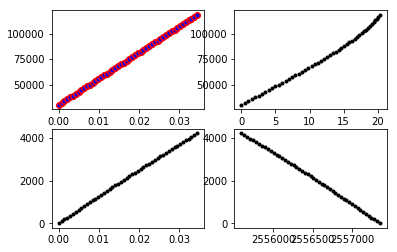

In [7]:
# If h_ref_water is selected properly, then axis2 (top right)
# should show a small difference between actual mixture enthalpy
# and that calculated from perfect gas theory, ie linear mixing
# (per 2009 ASHRAE Handbook - Fundamentals, Ch 1., Psychrometrics, eq. 29),
# especially the difference should approach zero near pure fluids.

# Note that some of the psychrometric functions don't behave well
# when inputting relative humidity of 0 or 1.

h_ref_water = CP.PropsSI('H','T',273.15,'Q',0,'water')
p,t = 80325, 303.15
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
w_max = HAP.HAPropsSI('W','P',p,'T',t,'RH',0.999)
h_da = HAP.HAPropsSI('Hda','P',p,'T',t,'W',0)
print(w_max)
for w in numpy.linspace(0.001,0.99) * w_max:
    rh = HAP.HAPropsSI('RH','P',p,'T',t,'W',w)
    p_w = HAP.HAPropsSI('P_w','P',p,'T',t,'W',w)
    h = HAP.HAPropsSI('Hda','P',p,'T',t,'W',w)
    h_w = CP.PropsSI('H','T',t,'P',p_w,'water') - h_ref_water
    h_calc = h_da + h_w * w
    #print(rh,h,h_w*w)
    ax1.plot(w,h,'ro')
    ax1.plot(w,h_calc,'b.')
    ax2.plot(h_calc - h,h,'k.')
    ax3.plot(w,p_w,'k.')
    ax4.plot(h_w,p_w,'k.')
plt.show()

In [18]:
dryair_mass_flow_in = 0.1
water_flow_in = 0.07
a_cell = 2.

nodal_temperature = []
nodal_relhum = []
nodal_humrat = []
nodal_water_flow = []
nodal_water_temperature = []
nodal_interface_humrat = []
pressure = 1e5
relhum_interface = 1

# Choose which case to try:

# Hot water and cool air in.
# Air can reach saturation before equilibrium with the water...
#water_flow_in = 10
#temperature_interface = 300
#temperature_far_in = 290
#relhum_far_in = 0.2

# Hot air, cool water in.
temperature_interface = 283
temperature_far_in = 303
relhum_far_in = 0.8

# From 2009 ASHRAE Handbook - Fundamentals, the example 6 in Ch. 6, Mass Transfer.
#temperature_interface = 35 + 273.15
#temperature_far_in = 18.3 + 273.15
#relhum_far_in = 0.1

nodal_temperature.append(temperature_far_in)
nodal_relhum.append(relhum_far_in)
humrat_far_in = HAP.HAPropsSI('HumRat','P',pressure,'T',temperature_far_in,'RH',relhum_far_in)
nodal_humrat.append(humrat_far_in)
nodal_water_flow.append(water_flow_in)
nodal_water_temperature.append(temperature_interface)
nodal_interface_humrat.append(HAP.HAPropsSI(
    'HumRat','P',pressure,'T',temperature_interface,'RH',relhum_interface))

for i in range(20):
    temperature_far = temperature_far_in
    relhum_far = relhum_far_in
    
    # Convert to dimensions we wish to average
    enthalpy_interface = HAP.HAPropsSI('Hha','P',pressure,'T',temperature_interface,'RH',relhum_interface)
    humrat_interface = HAP.HAPropsSI('HumRat','P',pressure,'T',temperature_interface,'RH',relhum_interface)
    mole_fraction_interface = HAP.HAPropsSI('Y','P',pressure,'T',temperature_interface,'RH',relhum_interface)
    mixture_density_interface = 1 / HAP.HAPropsSI('Vha','P',pressure,'T',temperature_interface,'RH',relhum_interface)
    vapor_density_interface = mole_fraction_interface * mixture_density_interface

    enthalpy_far = HAP.HAPropsSI('Hha','P',pressure,'T',temperature_far,'RH',relhum_far)
    humrat_far = HAP.HAPropsSI('HumRat','P',pressure,'T',temperature_far,'RH',relhum_far)
    mole_fraction_far = HAP.HAPropsSI('Y','P',pressure,'T',temperature_far,'RH',relhum_far)
    mixture_density_far = 1 / HAP.HAPropsSI('Vha','P',pressure,'T',temperature_far,'RH',relhum_far)
    vapor_density_far = mole_fraction_far * mixture_density_far

    enthalpy_vapor_interface = CP.PropsSI('H','T',temperature_interface,'Q',1,'water') \
        - h_ref_water
    
    # Now determine the film state and transport properties
    enthalpy_film = 0.5 * (enthalpy_interface + enthalpy_far)
    humrat_film = 0.5 * (humrat_interface + humrat_far)
    temperature_film = HAP.HAPropsSI('T','P',pressure,'Hha',enthalpy_film,'HumRat',humrat_film)
    relhum_film = HAP.HAPropsSI('RH','P',pressure,'Hha',enthalpy_film,'HumRat',humrat_film)
    volume = HAP.HAPropsSI('Vha','P',pressure,'Hha',enthalpy_film,'HumRat',humrat_film)
    density = 1 / volume
    c_p = HAP.HAPropsSI('Cha','P',pressure,'Hha',enthalpy_film,'HumRat',humrat_film)
    k = HAP.HAPropsSI('K','P',pressure,'Hha',enthalpy_film,'HumRat',humrat_film)
    mu = HAP.HAPropsSI('mu','P',pressure,'Hha',enthalpy_film,'HumRat',humrat_film)
    nu = mu * volume
    prandtl = c_p * mu / k
    #print(prandtl)
    #print(vapor_density_far, vapor_density_interface, mixture_density_far)

    length_scale = 0.01
    velocity = 1
    nusselt = 1
    h_heat = nusselt * k / length_scale
    stanton_heat = h_heat / (density * velocity * c_p)
    #print(stanton_heat)

    # Mass diffusivity [m2/s]
    diffusivity_mass = 2.5e-5
    schmidt = nu / diffusivity_mass
    lewis = schmidt / prandtl
    #print(lewis)

    stanton_ratio = pow(lewis, 2/3)
    #print(stanton_ratio)

    stanton_mass = stanton_heat / stanton_ratio
    h_mass = stanton_mass * velocity
    #print(h_mass)

    flow_per_area_mass = h_mass * (vapor_density_interface - vapor_density_far)
    flow_per_area_heat = h_heat * (temperature_interface - temperature_far)
    flow_per_area_mass, flow_per_area_heat

    mass_flow_cell = a_cell * flow_per_area_mass
    heat_flow_cell = a_cell * flow_per_area_heat

    # If the state is near saturation and getting closer,
    # then we need to dial down the water vapor influx.
    # Water vapor outflux is okay, as it tends to drive away from saturation.
    alpha = 1
    if relhum_film > 1 and mass_flow_cell > 0:
        mass_flow_cell = 0
    
    water_flow_out = water_flow_in - mass_flow_cell
    humrat_in = humrat_far
    humair_mass_flow_in = dryair_mass_flow_in * (1+humrat_in)
    humair_mass_flow_out = humair_mass_flow_in + mass_flow_cell
    humrat_out = humair_mass_flow_out / dryair_mass_flow_in - 1

    enthalpy_ave_in = enthalpy_far
    total_enthalpy_in = humair_mass_flow_in * enthalpy_ave_in
    total_enthalpy_out = total_enthalpy_in + heat_flow_cell \
        + mass_flow_cell * enthalpy_vapor_interface
    enthalpy_ave_out = total_enthalpy_out / humair_mass_flow_out
    
    water_total_enthalpy_in = water_flow_in * CP.PropsSI('H','T',temperature_interface,'Q',0,'water')
    water_total_enthalpy_out = water_total_enthalpy_in - heat_flow_cell \
        - mass_flow_cell * enthalpy_vapor_interface
    water_enthalpy_out = water_total_enthalpy_out / water_flow_out
    water_temperature_out = CP.PropsSI('T','H',water_enthalpy_out,'P',pressure,'water')
    #print(water_temperature_out)
    interface_humrat_out = HAP.HAPropsSI('HumRat','P',pressure,'T',water_temperature_out,'RH',relhum_interface)

    t_out = HAP.HAPropsSI('T','P',pressure,'Hha',enthalpy_ave_out,'HumRat',humrat_out)
    rh_out = HAP.HAPropsSI('RH','P',pressure,'Hha',enthalpy_ave_out,'HumRat',humrat_out)

    temperature_far_in = t_out
    relhum_far_in = rh_out
    water_flow_in = water_flow_out
    temperature_interface = water_temperature_out

    nodal_temperature.append(t_out)
    nodal_relhum.append(rh_out)
    nodal_humrat.append(humrat_out)
    nodal_water_flow.append(water_flow_out)
    nodal_water_temperature.append(water_temperature_out)
    nodal_interface_humrat.append(interface_humrat_out)

In [19]:
water_loss = nodal_water_flow[0] - nodal_water_flow[-1]
water_loss / nodal_water_flow[0]

-0.010673740626671431

In [20]:
import tabulate
HTML(tabulate.tabulate(zip(nodal_temperature,nodal_relhum,nodal_humrat,
                           nodal_water_flow,nodal_water_temperature,nodal_interface_humrat),
                       headers=['T_a','RH_a','omega_a',
                                'm_water','T_water','omega_i'],
                       tablefmt='html'))

T_a,RH_a,omega_a,m_water,T_water,omega_i
303,0.8,0.0217771,0.07,283,0.00768644
302.048,0.803277,0.0206621,0.0701115,284.268,0.00837443
301.196,0.805553,0.0196898,0.0702087,285.375,0.00901961
300.433,0.807281,0.0188461,0.0702931,286.338,0.00961675
299.749,0.808822,0.0181174,0.070366,287.173,0.010163
299.135,0.810446,0.0174908,0.0704286,287.895,0.0106577
298.585,0.812342,0.0169541,0.0704823,288.518,0.0111016
298.09,0.814628,0.0164961,0.0705281,289.054,0.011497
297.644,0.817365,0.0161066,0.070567,289.515,0.0118466
297.242,0.820572,0.0157765,0.0706001,289.91,0.0121541


In [21]:
# I'll use this instead, from now on
import pandas
pandas.DataFrame.from_dict(dict(T_air=nodal_temperature,
                            RelHum=nodal_relhum,
                            HumRat_air=nodal_humrat,
                            WaterFlow=nodal_water_flow,
                            T_water=nodal_water_temperature,
                            HumRat_interface=nodal_interface_humrat
                           ))

,HumRat_air,HumRat_interface,RelHum,T_air,T_water,WaterFlow
0,0.021777,0.007686,0.800000,303.000000,283.000000,0.070000
1,0.020662,0.008374,0.803277,302.048440,284.267861,0.070111
2,0.019690,0.009020,0.805553,301.196121,285.374757,0.070209
3,0.018846,0.009617,0.807281,300.432699,286.337722,0.070293
4,0.018117,0.010163,0.808822,299.748642,287.172819,0.070366
5,0.017491,0.010658,0.810446,299.135245,287.894982,0.070429
6,0.016954,0.011102,0.812342,298.584614,288.517925,0.070482
7,0.016496,0.011497,0.814628,298.089640,289.054102,0.070528
8,0.016107,0.011847,0.817365,297.643960,289.514715,0.070567
9,0.015777,0.012154,0.820572,297.241909,289.909753,0.070600


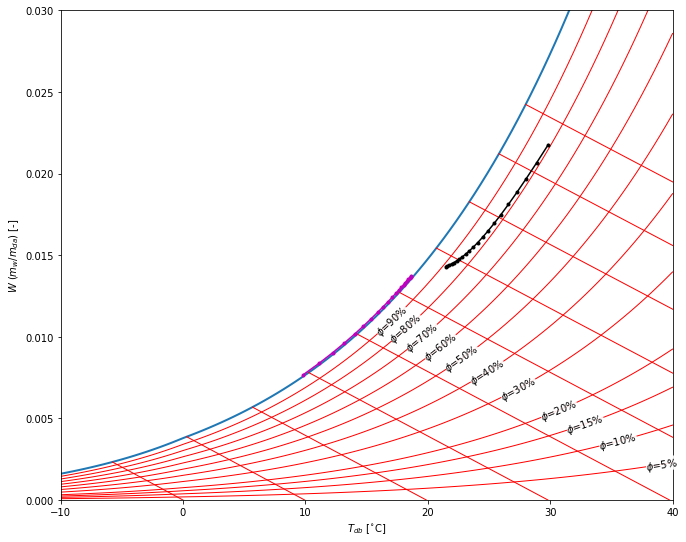

In [22]:
import CoolProp.Plots
import CoolProp.Plots.PsychChart
import CoolProp.Plots.PsychScript
#CoolProp.Plots.TwoStage('water',1,Te=280,Tc=300,DTsh=2,DTsc=2,eta_oi=0.9,f_p=0.1,Tsat_ic=290,DTsh_ic=2)
plt.close('all')
if True:
    from CoolProp.HumidAirProp import HAPropsSI
    from CoolProp.Plots.Plots import InlineLabel
    #from CoolProp.Plots.Common import BasePlot
    #bp = BasePlot()
    #InlineLabel = bp.inline_label

    p = 101325
    Tdb = numpy.linspace(-10,40,100)+273.15

    # Make the figure and the axes
    fig=matplotlib.pyplot.figure(figsize=(10,8))
    ax=fig.add_axes((0.1,0.1,0.85,0.85))
    
    # Saturation line
    w = [HAPropsSI('W','T',T,'P',p,'R',1.0) for T in Tdb]
    ax.plot(Tdb-273.15,w,lw=2)
        
    # Humidity lines
    RHValues = [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    for RH in RHValues:
        w = [HAPropsSI('W','T',T,'P',p,'R',RH) for T in Tdb]
        ax.plot(Tdb-273.15,w,'r',lw=1)
        
    # Humidity lines
    for H in [-20000, -10000, 0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000]:
        #Line goes from saturation to zero humidity ratio for this enthalpy
        T1 = HAPropsSI('T','H',H,'P',p,'R',1.0)-273.15
        T0 = HAPropsSI('T','H',H,'P',p,'R',0.0)-273.15
        w1 = HAPropsSI('W','H',H,'P',p,'R',1.0)
        w0 = HAPropsSI('W','H',H,'P',p,'R',0.0)
        ax.plot(numpy.r_[T1,T0],numpy.r_[w1,w0],'r',lw=1)
        
    ax.set_xlim(Tdb[0]-273.15,Tdb[-1]-273.15)
    ax.set_ylim(0,0.03)
    ax.set_xlabel(r"$T_{db}$ [$^{\circ}$C]")
    ax.set_ylabel(r"$W$ ($m_{w}/m_{da}$) [-]")
        
    xv = Tdb #[K]
    for RH in [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        yv = numpy.array([HAPropsSI('W','T',T,'P',p,'R',RH) for T in Tdb])
        #y = HAPropsSI('W','P',p,'H',65000.000000,'R',RH)
        y = HAPropsSI('W','P',p,'H',45000.000000,'R',RH)
        T_K,w,rot = InlineLabel(xv, yv, y=y, fig=fig, axis = ax)
        string = r'$\phi$='+'{s:0.0f}'.format(s=RH*100)+'%'
        bbox_opts = dict(boxstyle='square,pad=0.0',fc='white',ec='None',alpha = 0.9)
        ax.text(T_K-273.15,w,string,rotation = rot,ha ='center',va='center',bbox=bbox_opts)
    
ax.plot(numpy.array(nodal_temperature)-273.15,
        nodal_humrat,
        'k.-')
ax.plot(numpy.array(nodal_water_temperature)-273.15,
        nodal_interface_humrat,
       'm.-')
plt.show()

In [14]:
# Debug stuff
state=CP.AbstractState('HEOS','water')
print(state.backend_name())
print(state.fluid_names())

HelmholtzEOSBackend
[b'Water']


### Example 2

In [15]:
import fdm_evap

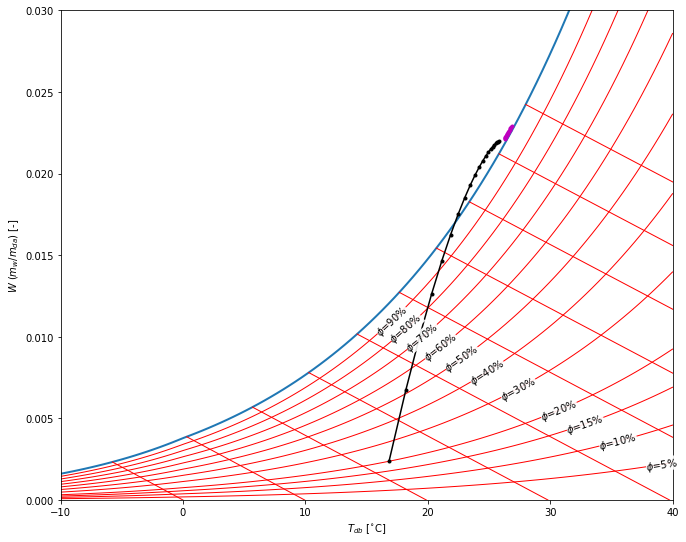

In [23]:
# For this figure, the method for proceeding into saturated states (fog)
# was to allow travel through supersaturated states (fog) as if nothing changes.
# This is not physical. Since condensate droplets are not vapor,
# ie. the vapor density doesn't increase beyond that at saturation,
# the droplets will be transported by advection but not by vapor diffusion/convection.
my_dataframe = fdm_evap.parallel_evaporation(
    water_flow_in = 10,
    temperature_interface = 300,
    temperature_far_in = 290,
    relhum_far_in = 0.2,
    a_cell=5,
    supersaturated_method=None
)
fdm_evap.plot_results(my_dataframe)

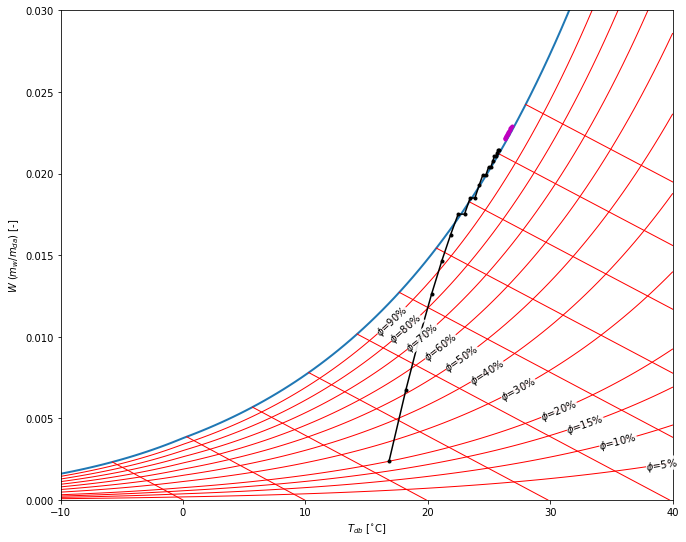

In [17]:
# For this figure, the method for proceeding along saturated states
# was to set mass transfer to zero iff the film state was supersaturated,
# in each cell. This is an ugly hack; need to project onto the saturation
# curve smoothly, for example.
my_dataframe = fdm_evap.parallel_evaporation(
    water_flow_in = 10,
    temperature_interface = 300,
    temperature_far_in = 290,
    relhum_far_in = 0.2,
    a_cell=5,
    supersaturated_method='hack'
)
fdm_evap.plot_results(my_dataframe)